In [188]:
import numpy as np
from scipy.stats import norm
# from sklearn.metrics import mean_squared_error
from filterpy.monte_carlo import systematic_resample
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os

In [189]:
# set model parameters
num_particles = 5_000

measurement_noise = 2_500
std_dev_increase = 000

In [190]:
# set prior distribution parameters for particles
particles = np.zeros((num_particles, 1))
weights = np.ones(num_particles) / num_particles

initial_pot_guess = 260_000
pot_guess_std = 100_000

particles = np.random.normal(loc=initial_pot_guess, scale=pot_guess_std, size=num_particles)
prior_distribution = particles.copy()

In [191]:
# set simulation parameters
true_pot_value = 305_000
win_probability = 0.05 
true_bid_value = true_pot_value * win_probability
bid_std = 0.10 * true_bid_value
n_bids = 64
n_simulations = 20

In [192]:
# helper functions
# prediction function to simulate particle evolution
def predict(particles, std_dev_increase):
    particles += np.random.normal(0, std_dev_increase, num_particles)

# define a function to map predicted pot sizes to predicted bids 
def bid_to_pot_size(pot_size, win_probability):
    return pot_size * win_probability

# function to update the particle weights based on observed bids
def update(particles, weights, observed_bid, win_probability, measurement_noise):
    for i, particle in enumerate(particles):
        predicted_bid = bid_to_pot_size(pot_size=particle, win_probability=win_probability)
        likelihood = norm.pdf(observed_bid, loc=predicted_bid, scale=measurement_noise)
        weights[i] *= likelihood
    # re-normalize weights
    weights /= np.sum(weights)  

def resample(particles, weights):
    indices = systematic_resample(weights)
    particles[:] = particles[indices]
    weights.fill(1.0 / num_particles)

def estimate(particles, weights):
    """Example estimate could be the weighted mean of the particles."""
    return np.average(particles, weights=weights, axis=0)

def particle_filter(particles, weights, std_dev_increase, measurement_noise, observed_bids, win_probability):
    estimates = []
    for observed_bid in observed_bids:
        predict(particles, std_dev_increase)
        update(particles, weights, observed_bid, win_probability, measurement_noise)
        resample(particles, weights)
        pot_estimate = estimate(particles, weights)
        estimates.append(pot_estimate)
    return np.array(estimates)

def reset_model(initial_pot_guess, pot_guess_std, num_particles):
    particles = np.random.normal(loc=initial_pot_guess, scale=pot_guess_std, size=num_particles)
    weights = np.ones(num_particles) / num_particles
    return particles, weights
        


In [193]:
# run the model
estimates_dic = {}
for i in range(n_simulations):
    particles, weights = reset_model(initial_pot_guess, pot_guess_std, num_particles)
    observed_bids = np.random.normal(loc=true_bid_value, scale=bid_std, size=n_bids)
    print(f'Running simulation {i + 1} of {n_simulations}')
    estimates = []
    for observed_bid in (observed_bids):
        predict(particles, std_dev_increase)
        update(particles, weights, observed_bid, win_probability, measurement_noise)
        resample(particles, weights)
        pot_estimate = estimate(particles, weights)
        estimates.append(pot_estimate)
    estimates_dic[i]= estimates

Running simulation 1 of 20


Running simulation 2 of 20
Running simulation 3 of 20
Running simulation 4 of 20
Running simulation 5 of 20
Running simulation 6 of 20
Running simulation 7 of 20
Running simulation 8 of 20
Running simulation 9 of 20
Running simulation 10 of 20
Running simulation 11 of 20
Running simulation 12 of 20
Running simulation 13 of 20
Running simulation 14 of 20
Running simulation 15 of 20
Running simulation 16 of 20
Running simulation 17 of 20
Running simulation 18 of 20
Running simulation 19 of 20
Running simulation 20 of 20


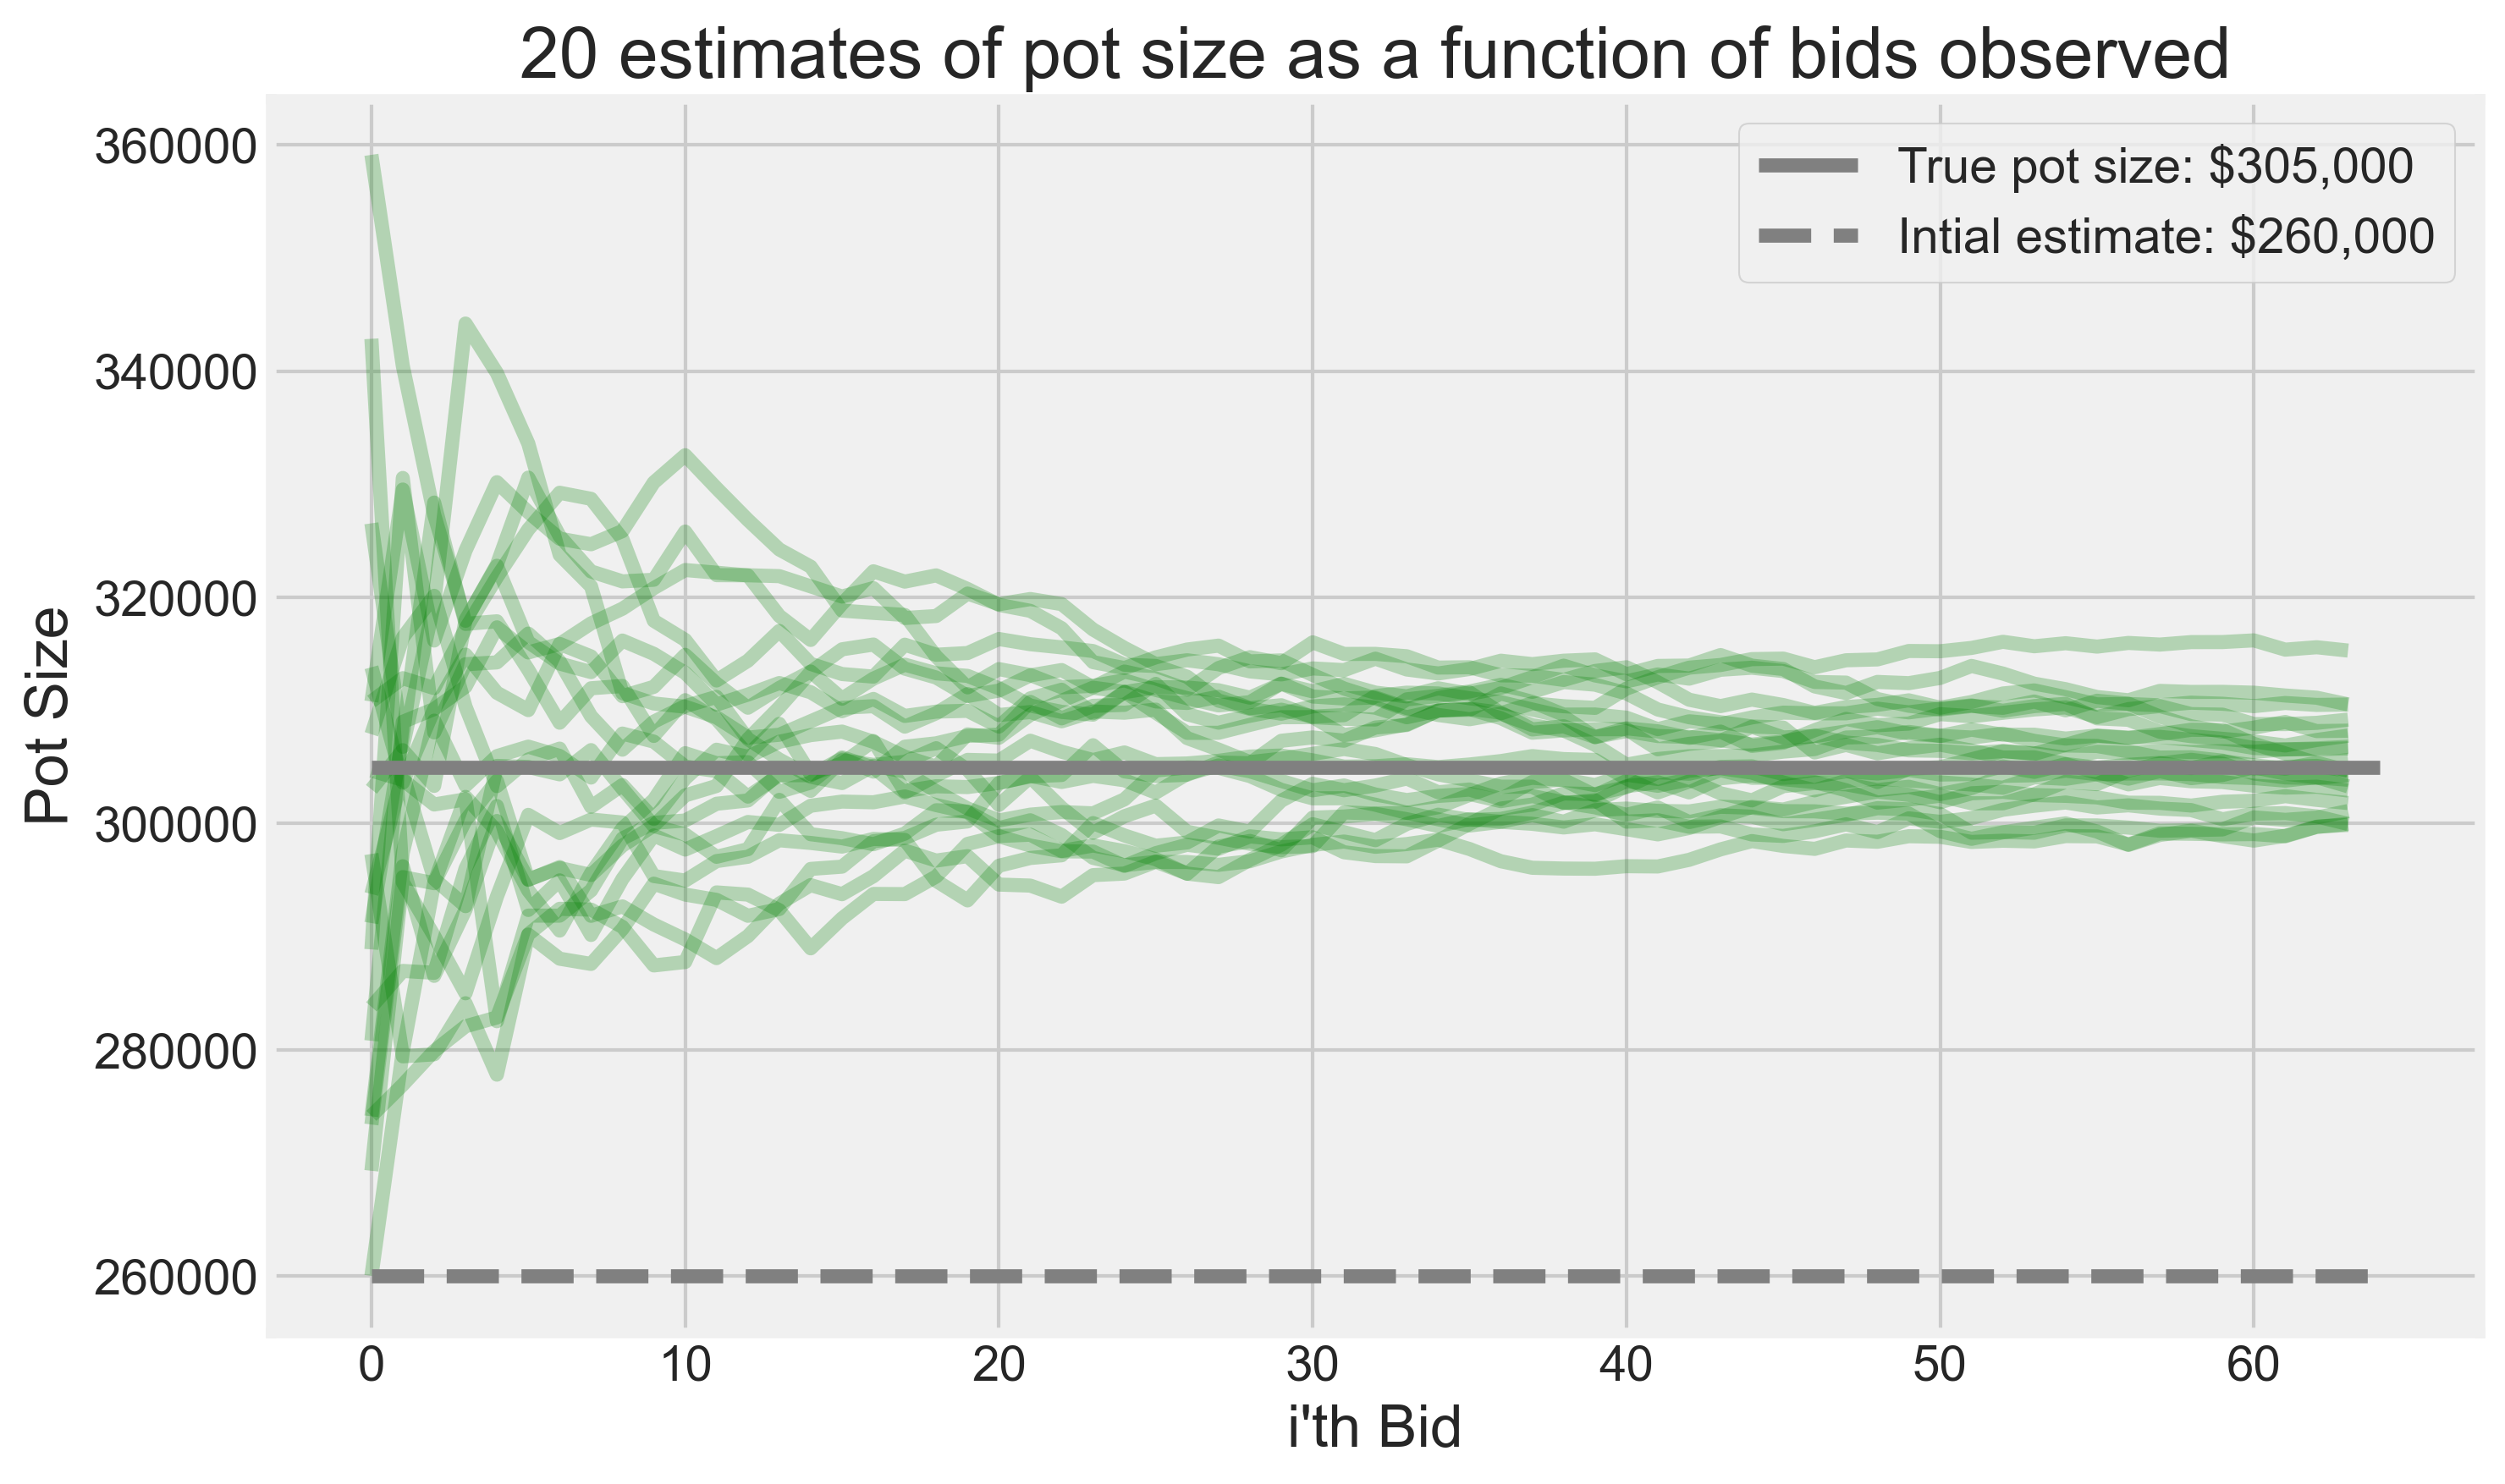

In [194]:
# visualize the results
plt.figure(figsize=(10, 6), dpi=300)
graphs_dir = 'outputs'
if not os.path.exists(graphs_dir):
    os.makedirs(graphs_dir)

x_plot = np.arange(n_bids)

plt.clf()
plt.style.use('fivethirtyeight')
plt.title(f'{n_simulations} estimates of pot size as a function of bids observed')
plt.ylabel('Pot Size')
plt.xlabel('i\'th Bid')
for i in range(n_simulations):
    plt.plot(x_plot, estimates_dic[i], color='green', alpha=0.25)
plt.hlines(y=true_pot_value, xmin=0, xmax=n_bids, colors='gray', label=f'True pot size: ${true_pot_value:,.0f}')
plt.hlines(y=initial_pot_guess, xmin=0, xmax=n_bids, colors='gray', linestyles='--', label=f'Intial estimate: ${initial_pot_guess:,.0f}')
plt.legend()
plt.show()

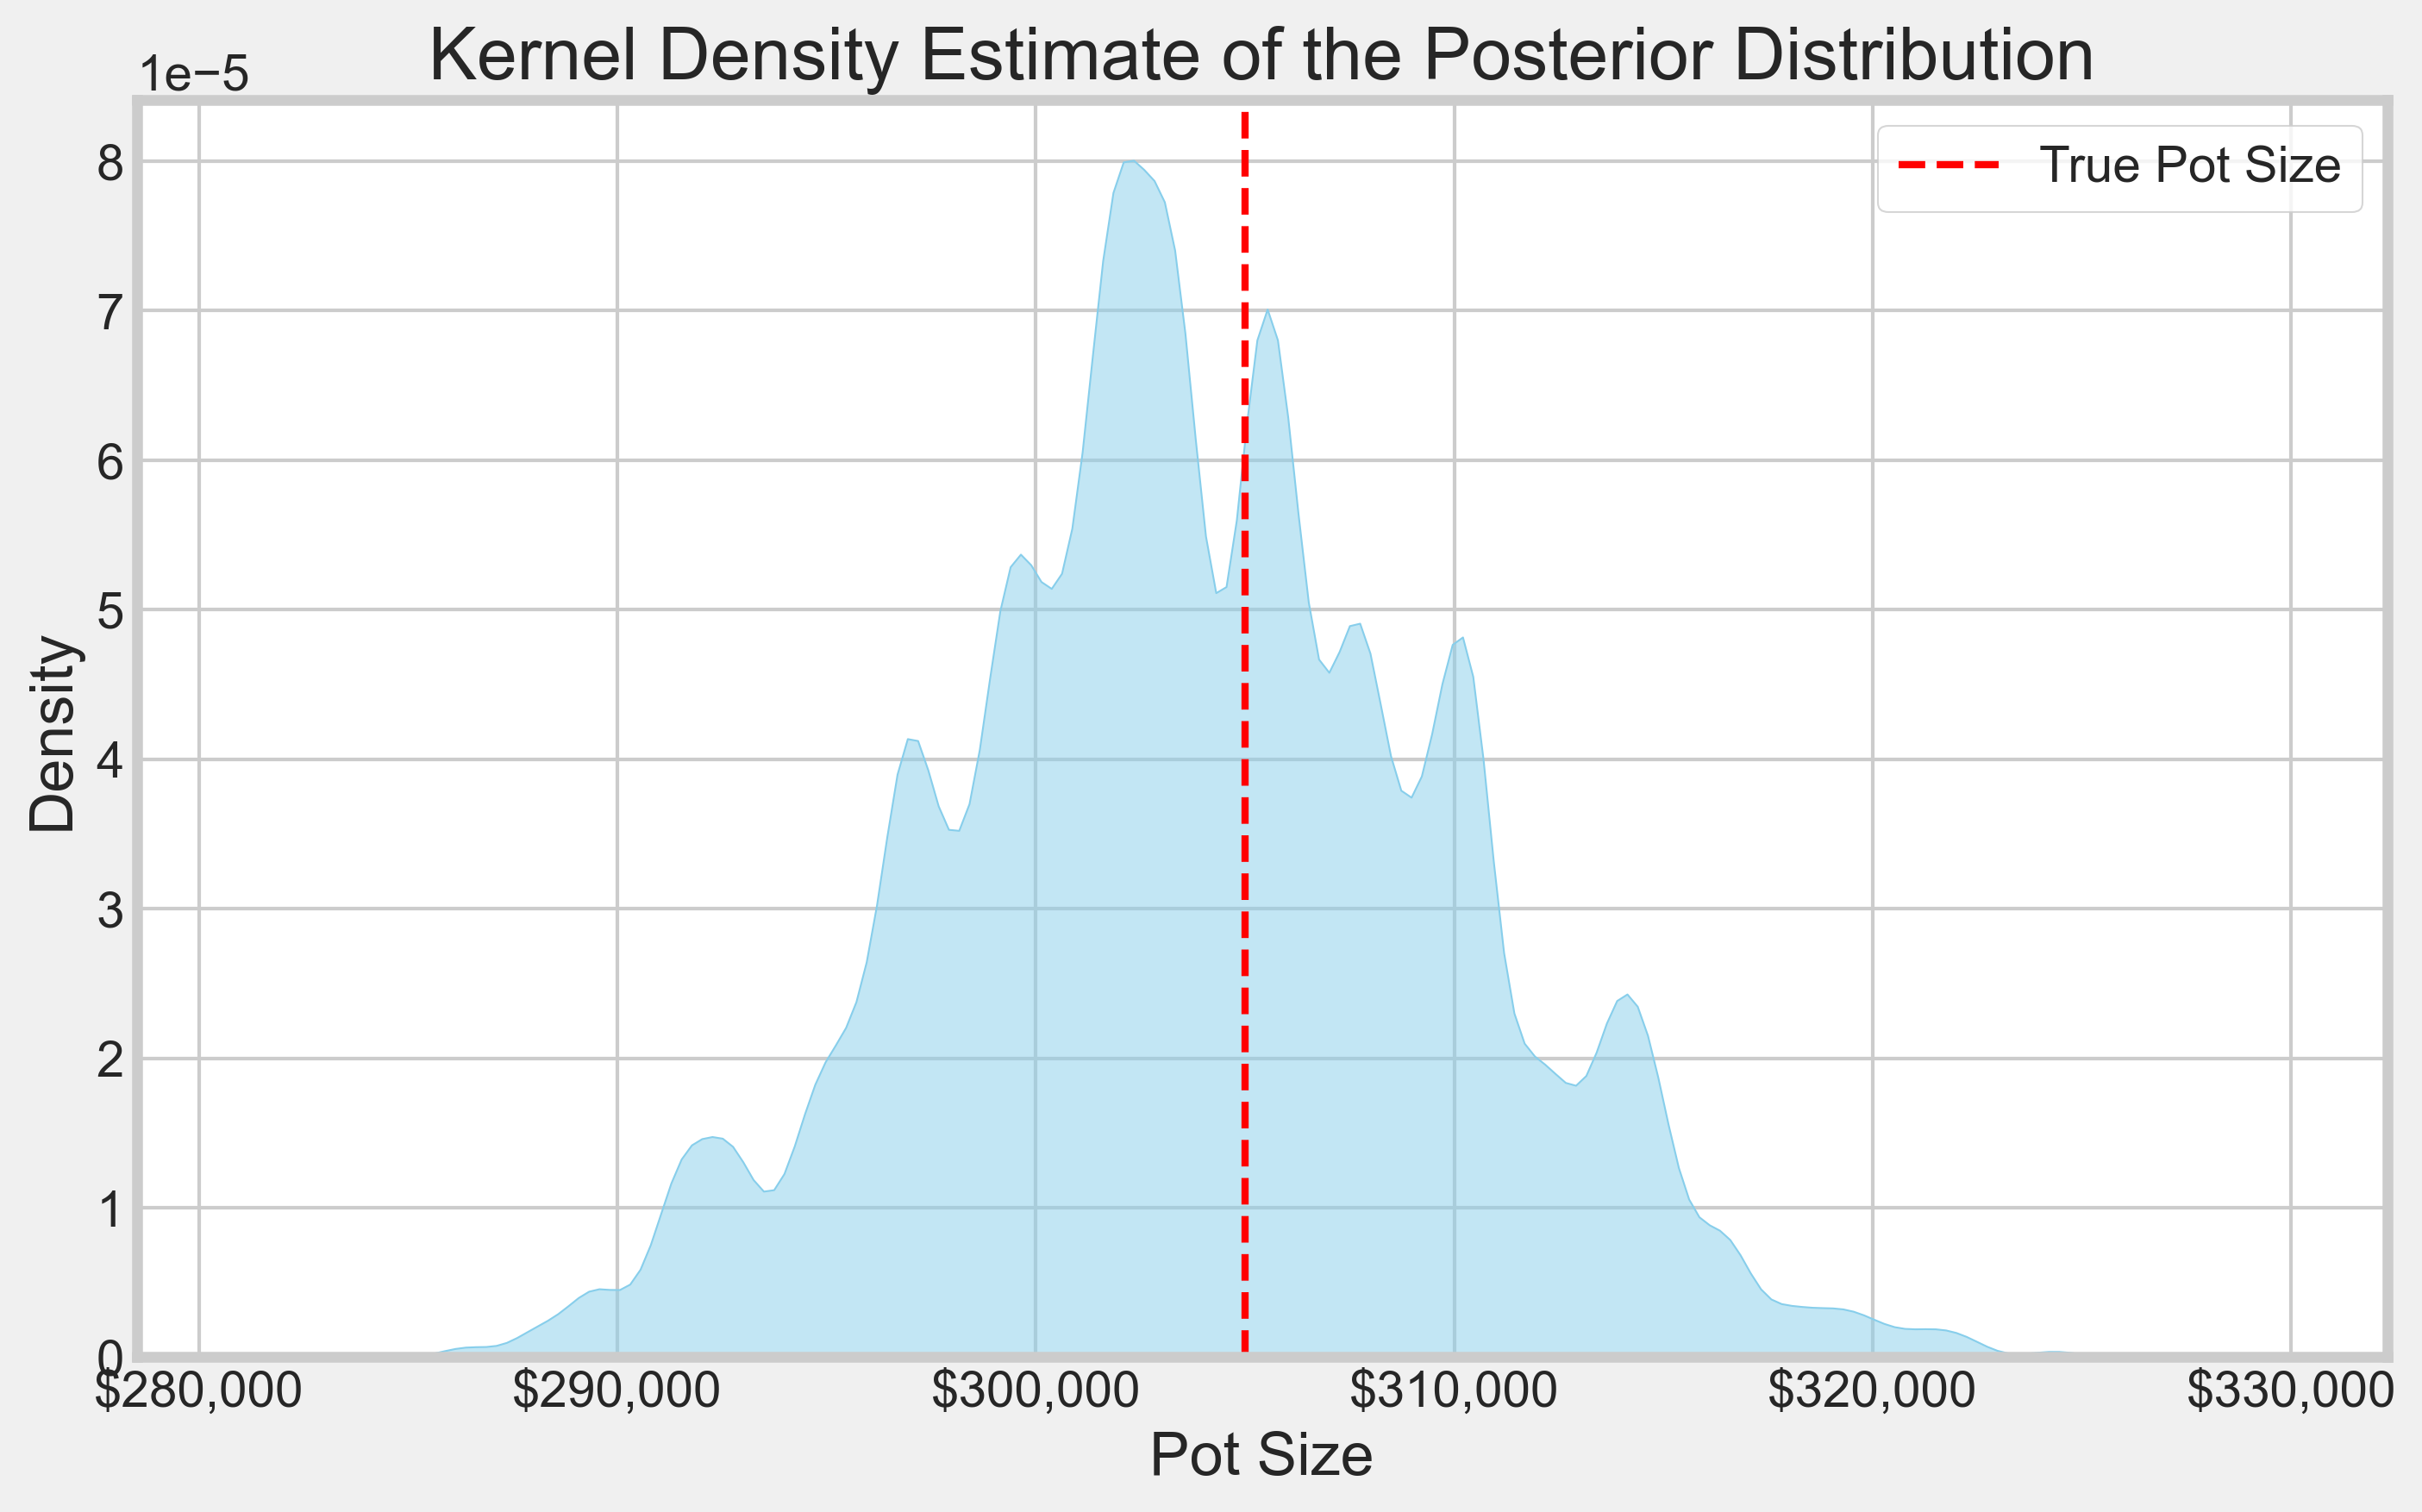

In [195]:
plt.figure(figsize=(10, 6), dpi=300)
sns.set_style("whitegrid")
# Create the KDE plot
sns.kdeplot(particles, bw_adjust=0.5, fill=True, color="skyblue", alpha=0.5)

# Add a vertical line for the true_pot_size
plt.axvline(x=true_pot_value, color='red', linestyle='--', linewidth=2, label='True Pot Size')

# Add legend, labels, and title
plt.legend()
plt.xlabel('Pot Size')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of the Posterior Distribution')

# Format the x-axis labels as currency
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${int(x):,}'))

# Show the plot
plt.show()

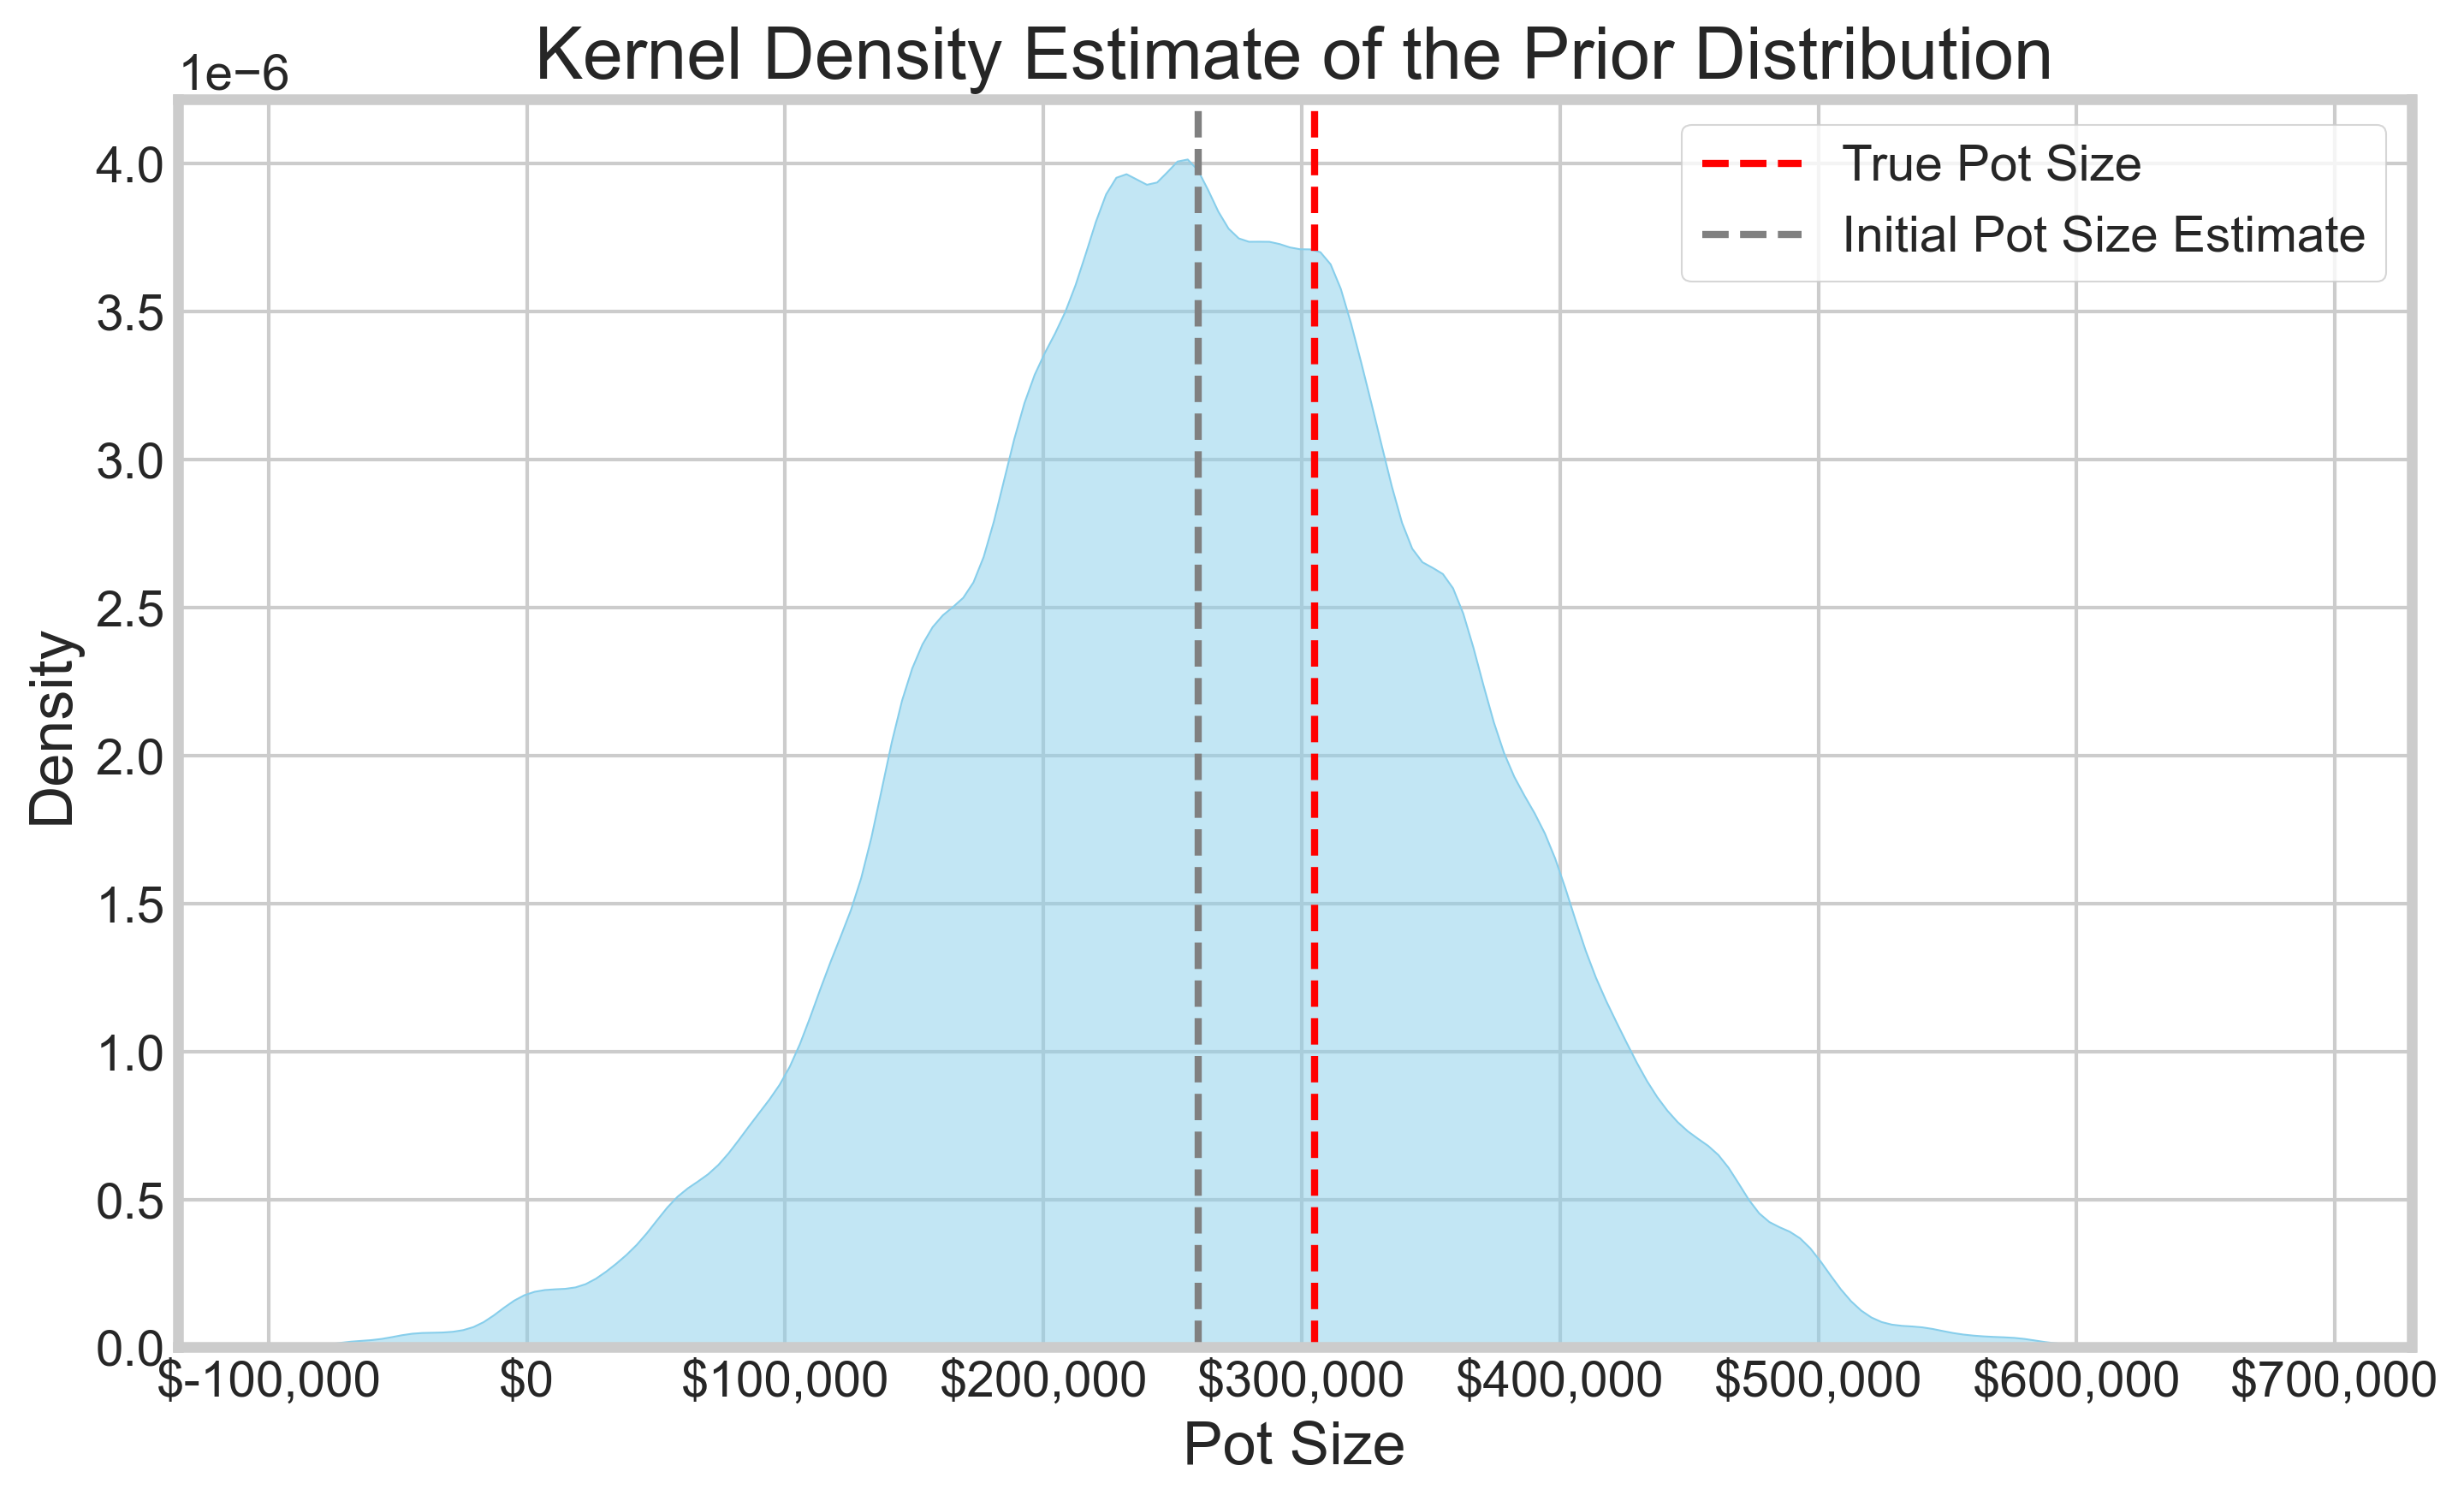

In [196]:
plt.figure(figsize=(10, 6), dpi=300)
sns.set_style("whitegrid")
# Create the KDE plot
sns.kdeplot(prior_distribution, bw_adjust=0.5, fill=True, color="skyblue", alpha=0.5)

# Add a vertical line for the true_pot_size
plt.axvline(x=true_pot_value, color='red', linestyle='--', linewidth=2, label='True Pot Size')
plt.axvline(x=initial_pot_guess, color='grey', linestyle='--', linewidth=2, label='Initial Pot Size Estimate')

# Add legend, labels, and title
plt.legend()
plt.xlabel('Pot Size')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of the Prior Distribution')

# Format the x-axis labels as currency
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${int(x):,}'))

# Show the plot
plt.show()